In [1]:
import zipfile
import os

zip_file_name = 'Dataset.zip' 

zip_file_path = os.path.join('.', zip_file_name)

extract_path = '.'

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"'{zip_file_name}' was successfully extracted.")
else:
    print(f"File '{zip_file_name}' not found in this path.")

'Dataset.zip' was successfully extracted.


In [2]:
import numpy as np
import pandas as pd

train_dir = 'Training'
test_dir = 'Testing'

if os.path.exists(train_dir) and os.path.exists(test_dir):
    print(f"\nFolder '{train_dir}' found.")
    print(f"Folder '{test_dir}' found.")
    
    class_names = sorted(os.listdir(train_dir))
    
    print("\nMain paths defined:")
    print(f"Training path: {train_dir}")
    print(f"Test path: {test_dir}")
    print(f"classes: {class_names}")
    
    print("\n Number of images per class (education folder) :")
    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        num_images = len(os.listdir(class_path))
        print(f"{class_name}: {num_images} تصویر")
else:
    print("\nTraining and/or Testing folders not found.")


Folder 'Training' found.
Folder 'Testing' found.

Main paths defined:
Training path: Training
Test path: Testing
classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

 Number of images per class (education folder) :
glioma_tumor: 826 تصویر
meningioma_tumor: 822 تصویر
no_tumor: 395 تصویر
pituitary_tumor: 827 تصویر


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score

In [4]:
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

In [5]:
X_train = []
Y_train = []
image_size = 224  
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

for i in labels:
    folderPath = os.path.join('Training', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)

for i in labels:
    folderPath = os.path.join('Testing', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

print(f"Total images in X_train: {len(X_train)}")
print(f"Images resized to {image_size}x{image_size}.")

Total images in X_train: 3264
Images resized to 224x224.


In [6]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(3264, 224, 224, 3)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.1,random_state=101)

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMAGE_SIZE = 224
PATCH_SIZE = 16  
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64  
NUM_HEADS = 4  
TRANSFORMER_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]  
TRANSFORMER_LAYERS = 4  
MLP_HEAD_UNITS = [2048, 1024]
NUM_CLASSES = 4


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


def create_vit_classifier():
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    patches = Patches(PATCH_SIZE)(inputs)
    
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    for _ in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM // NUM_HEADS, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(TRANSFORMER_UNITS[0], activation=tf.nn.gelu)(x3)
        x3 = layers.Dense(TRANSFORMER_UNITS[1], activation=tf.nn.gelu)(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    features = layers.Dense(MLP_HEAD_UNITS[0], activation='relu')(representation)
    features = layers.Dropout(0.5)(features)
    features = layers.Dense(MLP_HEAD_UNITS[1], activation='relu')(features)
    logits = layers.Dense(NUM_CLASSES, activation="softmax")(features)
    
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

model = create_vit_classifier()

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ patches (Patches)             │ (None, None, 768)         │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ patch_encoder (PatchEncoder)  │ (None, 196, 64)           │          61,760 │ patches[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 196, 64)           │             128 │ patch_encoder[0][0]        │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 196, 64)           │          16,640 │ layer_normalization[0][0], │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 196, 64)           │               0 │ multi_head_attention[0][0… │
│                               │                           │                 │ patch_encoder[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 196, 64)           │             128 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 196, 128)          │           8,320 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 196, 64)           │           8,256 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 196, 64)           │               0 │ dense_2[0][0], add[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 196, 64)           │             128 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 196, 64)           │          16,640 │ layer_normalization_2[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 196, 64)           │               0 │ multi_head_attention_1[0]… │
│                               │                           │                 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_3         │ (None, 196, 64)           │             12

 Total params: 2,431,172 (9.27 MB)

 Trainable params: 2,431,172 (9.27 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [12]:
history = model.fit(X_train,y_train,epochs=20,validation_split=0.1)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 236ms/step - accuracy: 0.3265 - loss: 1.4074 - val_accuracy: 0.3265 - val_loss: 1.2896
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/step - accuracy: 0.4211 - loss: 1.2732 - val_accuracy: 0.4694 - val_loss: 1.1901
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/step - accuracy: 0.4328 - loss: 1.2065 - val_accuracy: 0.5272 - val_loss: 1.1415
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/step - accuracy: 0.4915 - loss: 1.1349 - val_accuracy: 0.5170 - val_loss: 1.1419
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.5252 - loss: 1.0494 - val_accuracy: 0.5612 - val_loss: 0.9731
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - accuracy: 0.5902 - loss: 0.9775 - val_accuracy: 0.6395 - val_loss: 0.8770
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.6110 - loss: 0.9273 - val_accuracy: 0.6429 - val_loss: 0.8600
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.6110 - loss: 0.9392 - val_accu

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

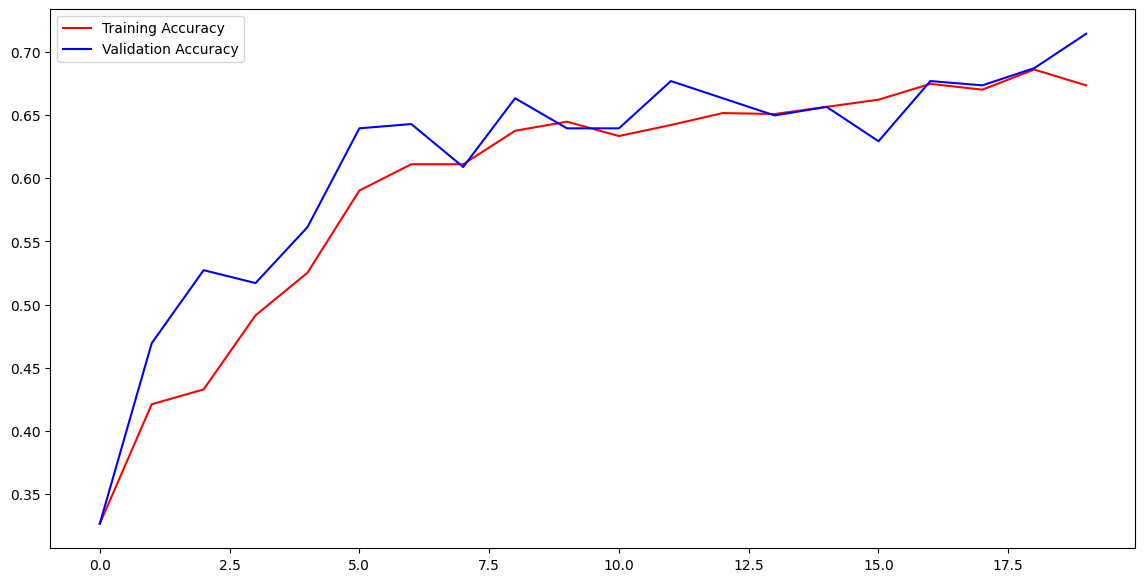

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

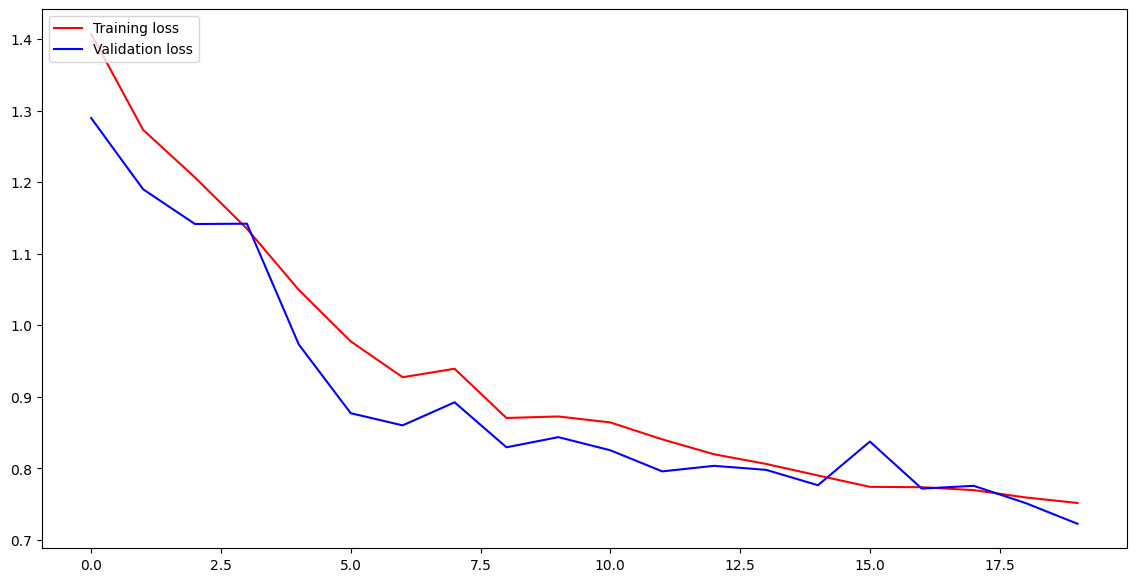

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [16]:
import random

random_index = random.randint(0, len(X_test) - 1)

random_image = X_test[random_index]
true_label_one_hot = y_test[random_index]

print(f"Selected image dimensions: {random_image.shape}")

image_for_prediction = np.expand_dims(random_image, axis=0)
print(f"Image dimensions for model input: {image_for_prediction.shape}")

prediction = model.predict(image_for_prediction)

predicted_class_index = np.argmax(prediction)
true_class_index = np.argmax(true_label_one_hot)

predicted_label = labels[predicted_class_index]
true_label = labels[true_class_index]

print(f"\nActual label: {true_label}")
print(f"Predicted label: {predicted_label}")

Selected image dimensions: (224, 224, 3)
Image dimensions for model input: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step

Actual label: meningioma_tumor
Predicted label: meningioma_tumor


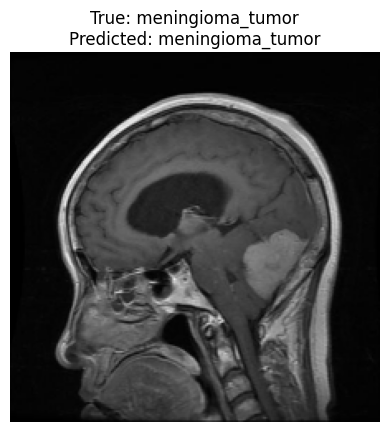

In [17]:
plt.imshow(random_image)
plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
plt.axis('off') 
plt.show()